## Using MoVi data in Python

MoVi dataset is originally provided as `.mat` format.  
We provide some utility functions to make it easy reading MoVi files in Python environment

In [1]:
# preliminaries
!pip install utils
!pip install readmat
!pip install human_body_prior
!git clone https://github.com/saeed1262/MoVi-Toolbox
%cd MoVi-Toolbox/
from MoCap.utils import *
from readmat import mat2dict as m2d
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 124 kB 49.0 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 3.3 MB 36.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 635 kB 33.7 MB/s 
     |████████████████████████████████| 1.2 MB 40.8 MB/s 
     |████████████████████████████████| 890 kB 32.5 MB/s 
     |████████████████████████████████| 2.2 MB 49.7 MB/s 
  Created wheel for human-body-prior: filename=human_body_prior-0.8.5.0-py3-none-any.whl size=42351 sha256=090c0ec7f82fced506a4e15f41d202419a904da7e9b9d67f5977915b0b2b9610
  Stored in directory: /root/.cache/pip/wheels/9a/29/91/610481655febd2e31aee77f004e321ace6b48bf0086054b19c
  Created wheel for configer: filename=configer-1.3.1-py3-none-any.whl size=4513 sha256=16dd78cea5fa5ff21b66353c1e61bcbe9ab9d0df56f53d65bfc5a183e8a4101b
  Stored in directory: /root/.cache/pip/wheels/3e/00/62/070eb39a8bf35db9dbb001c01da3788956883426a18e7770f4
 

Custom data loader

Load an IMU data file

In [ ]:
base_path = '/content/drive/MyDrive/Neuromatch/'
I1_path = base_path +'MoVi Data/IMU_Subjects/multi/10_I1.csv' #subject 10
imu_filename = base_path + 'MoVi Data/IMU_Subjects/imu_Subject_3.mat'
imu_header_filename = base_path + 'Code/imu_header.mat'


## Reading MoVi files as a Python dictionary
sample = mat2dict(imu_filename)
#sample.keys()

# get header specifying data fields
imu_hdr = m2d(imu_header_filename)['imu_data_header']

# get joint segment lengths (I made these up just to plot pose)
joints = pd.read_csv(base_path + 'Code/joints_len.csv')

In [ ]:
I1_data= pd.read_csv(I1_path)
I1_data.head()

,Hip-X-x,Hip-X-y,Hip-X-z,Hip-V-x,Hip-V-y,Hip-V-z,Hip-Q-s,Hip-Q-x,Hip-Q-y,Hip-Q-z,Hip-A-x,Hip-A-y,Hip-A-z,Hip-W-x,Hip-W-y,Hip-W-z,RightUpLeg-X-x,RightUpLeg-X-y,RightUpLeg-X-z,RightUpLeg-V-x,RightUpLeg-V-y,RightUpLeg-V-z,RightUpLeg-Q-s,RightUpLeg-Q-x,RightUpLeg-Q-y,RightUpLeg-Q-z,RightUpLeg-A-x,RightUpLeg-A-y,RightUpLeg-A-z,RightUpLeg-W-x,RightUpLeg-W-y,RightUpLeg-W-z,RightLeg-X-x,RightLeg-X-y,RightLeg-X-z,RightLeg-V-x,RightLeg-V-y,RightLeg-V-z,RightLeg-Q-s,RightLeg-Q-x,...,Spine2-A-y,Spine2-A-z,Spine2-W-x,Spine2-W-y,Spine2-W-z,Spine1-X-x,Spine1-X-y,Spine1-X-z,Spine1-V-x,Spine1-V-y,Spine1-V-z,Spine1-Q-s,Spine1-Q-x,Spine1-Q-y,Spine1-Q-z,Spine1-A-x,Spine1-A-y,Spine1-A-z,Spine1-W-x,Spine1-W-y,Spine1-W-z,Spine-X-x,Spine-X-y,Spine-X-z,Spine-V-x,Spine-V-y,Spine-V-z,Spine-Q-s,Spine-Q-x,Spine-Q-y,Spine-Q-z,Spine-A-x,Spine-A-y,Spine-A-z,Spine-W-x,Spine-W-y,Spine-W-z,subject_number,timestamp,session
0,-0.0407,-0.0211,-0.0186,0.0046,0.0029,-0.0026,-0.1586,0.6798,0.1631,0.6972,-0.9609,-0.0938,0.2656,-0.0175,-0.0175,0.0000,-0.1007,0.0763,0.2104,0.0021,0.0026,-0.0028,0.9993,0.0338,0.0137,0.0101,-1.0000,0.0156,-0.168,-0.0175,0.0,0.0,-0.1136,0.0645,0.627,0.0009,0.0014,-0.0022,0.9995,-0.0326,...,-0.1016,-0.1250,0.0000,0.0524,0.0000,-0.0451,-0.0339,-0.3268,0.0063,0.0024,-0.0022,0.9941,-0.0124,-0.1022,-0.0357,-0.9922,-0.1016,-0.1250,0.0000,0.0524,0.0000,-0.0385,-0.0245,-0.2221,0.0079,0.0036,-0.0026,1.0,-0.0,-0.0,-0.0,-0.9609,-0.0938,0.2656,-0.0175,-0.0175,0.0000,10,0,I1
1,-0.0406,-0.0211,-0.0186,0.0043,0.0030,-0.0027,-0.1586,0.6798,0.1631,0.6972,-0.9609,-0.0938,0.2656,-0.0175,-0.0175,0.0000,-0.1007,0.0763,0.2104,0.0019,0.0027,-0.0029,0.9993,0.0338,0.0137,0.0101,-1.0000,0.0156,-0.168,-0.0175,0.0,0.0,-0.1135,0.0645,0.627,0.0008,0.0015,-0.0023,0.9995,-0.0326,...,-0.1016,-0.1250,0.0000,0.0524,0.0000,-0.0450,-0.0339,-0.3268,0.0059,0.0025,-0.0024,0.9941,-0.0124,-0.1022,-0.0357,-0.9922,-0.1016,-0.1250,0.0000,0.0524,0.0000,-0.0384,-0.0245,-0.2221,0.0076,0.0037,-0.0028,1.0,-0.0,-0.0,-0.0,-0.9609,-0.0938,0.2656,-0.0175,-0.0175,0.0000,10,1,I1
2,-0.0405,-0.0211,-0.0186,0.0000,0.0005,-0.0016,-0.1589,0.6796,0.1632,0.6974,-0.9570,-0.0938,0.2695,-0.0175,-0.0175,0.0000,-0.1007,0.0763,0.2104,-0.0010,0.0012,-0.0019,0.9993,0.0335,0.0134,0.0101,-1.0000,0.0156,-0.168,-0.0175,0.0,0.0,-0.1135,0.0645,0.627,-0.0011,0.0001,-0.0010,0.9995,-0.0325,...,-0.0977,-0.1406,0.0175,0.0175,0.0000,-0.0449,-0.0339,-0.3268,0.0021,0.0001,-0.0012,0.9940,-0.0131,-0.1031,-0.0355,-0.9961,-0.0977,-0.1406,0.0175,0.0175,0.0000,-0.0383,-0.0245,-0.2221,0.0030,0.0009,-0.0016,1.0,-0.0,-0.0,-0.0,-0.9570,-0.0938,0.2695,-0.0175,-0.0175,0.0000,10,2,I1
3,-0.0405,-0.0210,-0.0186,-0.0054,0.0047,-0.0010,-0.1589,0.6795,0.1632,0.6974,-0.9570,-0.0938,0.2695,-0.0175,-0.0175,-0.0175,-0.1007,0.0763,0.2104,-0.0050,0.0034,-0.0028,0.9993,0.0334,0.0134,0.0101,-1.0000,0.0156,-0.168,-0.0175,0.0,0.0,-0.1136,0.0645,0.627,-0.0040,0.0016,-0.0018,0.9995,-0.0324,...,-0.0898,-0.1484,0.0000,0.0000,-0.0175,-0.0449,-0.0339,-0.3268,-0.0001,0.0004,-0.0007,0.9940,-0.0133,-0.1032,-0.0355,-0.9961,-0.0898,-0.1484,0.0000,0.0000,-0.0175,-0.0383,-0.0244,-0.2221,-0.0004,0.0017,-0.0009,1.0,-0.0,-0.0,0.0,-0.9570,-0.0938,0.2695,-0.0175,-0.0175,-0.0175,10,3,I1
4,-0.0405,-0.0210,-0.0186,-0.0049,0.0043,-0.0009,-0.1589,0.6795,0.1632,0.6974,-0.9570,-0.0938,0.2695,-0.0175,-0.0175,-0.0175,-0.1007,0.0763,0.2104,-0.0058,0.0042,-0.0028,0.9993,0.0335,0.0134,0.0101,-0.9961,0.0156,-0.168,-0.0175,0.0,0.0,-0.1136,0.0645,0.627,-0.0047,0.0018,-0.0021,0.9995,-0.0326,...,-0.0898,-0.1445,0.0000,0.0000,-0.0175,-0.0448,-0.0339,-0.3268,0.0006,0.0007,-0.0005,0.9939,-0.0133,-0.1034,-0.0355,-1.0000,-0.0898,-0.1445,0.0000,0.0000,-0.0175,-0.0382,-0.0244,-0.2221,-0.0003,0.0022,-0.0008,1.0,-0.0,-0.0,0.0,-0.9570,-0.0938,0.2695,-0.0175,-0.0175,-0.0175,10,4,I1


Some lines of code to look at the data structure

Set up pose plotting

In [ ]:
# define a tree structure of body segments
joint_tree = {
    'Hip':           {'ind':0,'children':['RightUpLeg','LeftUpLeg']},
    'RightUpLeg':    {'ind':1 ,'children':['RightLeg']},
    'RightLeg':      {'ind':2 ,'children':['RightFoot']},
    'RightFoot':     {'ind':3 ,'children':['none']},
    'LeftUpLeg':     {'ind':4,'children':['LeftLeg']},
    'LeftLeg':       {'ind':5,'children':['LeftFoot']},
    'LeftFoot':      {'ind':6,'children':['none']},
    'RightShoulder': {'ind':7,'children':['RightArm']},
    'RightArm':      {'ind':8,'children':['RightForeArm']},
    'RightForeArm':  {'ind':9,'children':['RightHand']},
    'RightHand':     {'ind':10,'children':['none']},
    'LeftShoulder':  {'ind':11,'children':['LeftArm']},
    'LeftArm':       {'ind':12,'children':['LeftForeArm']},
    'LeftForeArm':   {'ind':13,'children':['LeftHand']},
    'LeftHand':      {'ind':14,'children':['none']},
    'Neck':          {'ind':15,'children':['Spine1']},
    'Spine1':        {'ind':16,'children':['LeftShoulder','RightShoulder','Hip']},
}

joint_tree2 = {
    'Hip':           {'ind':0,'children':['RightUpLeg','LeftUpLeg','Spine1']},
    'RightUpLeg':    {'ind':1 ,'children':['RightLeg']},
    'RightLeg':      {'ind':2 ,'children':['RightFoot']},
    'RightFoot':     {'ind':3 ,'children':['none']},
    'LeftUpLeg':     {'ind':4,'children':['LeftLeg']},
    'LeftLeg':       {'ind':5,'children':['LeftFoot']},
    'LeftFoot':      {'ind':6,'children':['none']},
    'RightShoulder': {'ind':7,'children':['RightArm']},
    'RightArm':      {'ind':8,'children':['RightForeArm']},
    'RightForeArm':  {'ind':9,'children':['RightHand']},
    'RightHand':     {'ind':10,'children':['none']},
    'LeftShoulder':  {'ind':11,'children':['LeftArm']},
    'LeftArm':       {'ind':12,'children':['LeftForeArm']},
    'LeftForeArm':   {'ind':13,'children':['LeftHand']},
    'LeftHand':      {'ind':14,'children':['none']},
    'Neck':          {'ind':15,'children':['none']},
    'Spine1':        {'ind':16,'children':['LeftShoulder','RightShoulder','Neck2']},
}

# to convert data matrix into rotation matrices of joint orientation
def get_rot_mats(sample,imu_hdr):
    # first get orientation data, not velocity, acc, etc
    quat_inds = np.flatnonzero(np.core.defchararray.find(imu_hdr.astype('U'),"Q")!=-1)
    # get quaternions as samples*joints X 4
    quaternions = sample['S2']['data'][:,quat_inds].reshape(-1,4)
    print(quaternions[0])
    r = R.from_quat(quaternions[:,[1,2,3,0]])
    # get rotation matrices
    rot_mats = r.as_matrix()
    # get rot mats as samples X joints X 3 X 3
    rot_mats = rot_mats.reshape(-1,21,3,3)
    # throw out channels with blank data
    quat_sample = sample['S1']['data'][1,quat_inds].reshape(-1,4)
    junkInds = np.all(quat_sample[:,1:4] == 0,1)
    rot_mats = rot_mats[:,~junkInds,:,:]
    return rot_mats

# get 3d vectors orientation from rotation matrices for plotting
def get_orientations(rot_mats,joints):
    nSamps = rot_mats.shape[0]
    nJoints = rot_mats.shape[1]
    unit3 = np.array([1,1,1])
    # initialize orientation vectors
    orientations = np.zeros((nSamps,nJoints,3))
    for sampi in range(nSamps): # for each sample
        rot_mat_samp = rot_mats[sampi]
        for i in range(len(rot_mat_samp)): # for each segment
            # multiply unit vector by rotation matrix to get orientation
            orientations[sampi,i,:] = rot_mats[sampi,i] @ (unit3)*joints.len[i]
    return orientations

# align orientation vectors to z axis
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def align_orientations(orientations):
    vecs = orientations.reshape(-1,3)
    baselineVec = np.mean(vecs[0:128,:],0)
    alignmentRot = rotation_matrix_from_vectors(baselineVec, [0,0,-1])
    aligned = alignmentRot @ vecs.T
    aligned = aligned.T
    return aligned.reshape(orientations.shape)

def normalize_rotations(rot_mats,refi):
    # choose one IMU sensor as reference
    # multiply all rotations by the inverse of the reference rotation
    # inputs: rot_mats- samples X sensors X 3X3 rotation matrices
    #         redi- index of reference sensor
    # output: rot_mats_norm: normalized rotation matrices
    sampN = rot_mats.shape[0]
    sensorN = rot_mats.shape[1]
    rot_mats_norm = np.zeros_like(rot_mats)
    for sampi in range(sampN):
        refRot = rot_mats[sampi,refi]
        refInv = R.from_matrix(refRot).inv().as_matrix()
        for sensori in range(sensorN):
            rot_mats_norm[sampi,sensori,:,:] = refInv @ rot_mats[sampi,sensori,:,:]
    return rot_mats_norm

# Modify the segment lengths
joints = pd.read_csv(base_path + 'Code/joints_len.csv')
joints.loc[joints['joints']=='Hip','len']=1
joints.loc[joints['joints']=='Spine1','len']=0.1

# get rotation matrices and orientation vectors
refi = joint_tree['Neck']['ind']
rot_mats = get_rot_mats(sample,imu_hdr)
rot_mats = normalize_rotations(rot_mats,refi)
orientations = get_orientations(rot_mats,joints)
#orientations = normalize_orientations(orientations,0)
orientations = align_orientations(orientations)


[-0.1283  0.6986  0.1421  0.6895]


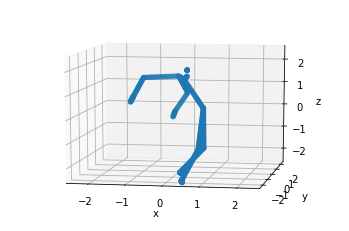

In [ ]:
# plot pose using recursive tree algorithm from neck down
def plot_pose(joint_tree,orientations):
    def get_child_pose(seg):
        segi = joint_tree[seg]['ind']
        seg_children = joint_tree[seg]['children']
        dots = np.array([0,0,0])
        if seg_children[0] != 'none':
            for child in seg_children:
                childi = joint_tree[child]['ind']
                segment_vecs[childi] = segment_vecs[segi] + orientations[childi]
                # recursive function call to children
                segDots = np.vstack((np.linspace(segment_vecs[segi][0], segment_vecs[childi][0],25 ),
                                     np.linspace(segment_vecs[segi][1], segment_vecs[childi][1],25 ),
                                     np.linspace(segment_vecs[segi][2], segment_vecs[childi][2],25 ))).T
                dots = np.vstack((dots,segDots,get_child_pose(child)))
            return dots
        else:
            return np.array([0,0,0]) 
    root = "Neck"
    rooti = joint_tree[root]['ind']
    # initialize position of segment endpoints relative to each other
    segment_vecs = np.zeros_like(orientations)
    segment_vecs[rooti] = orientations[rooti]
    dots = get_child_pose(root)
    return dots

# plot a single pose
dots = plot_pose(joint_tree,orientations[6101,:,:])
dots = dots-dots.mean(axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dots[:,0],dots[:,1],dots[:,2])
ax.set_xlim3d(-2.5, 2.5)
ax.set_ylim3d(-2.5, 2.5)
ax.set_zlim3d(-2.5, 2.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=10, azim=280)
plt.show()


In [ ]:
import matplotlib.animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128
#%matplotlib notebook

def update_graph(num):
    dots = plot_pose(joint_tree,orientations[num,:,:])
    dots = dots-dots.mean(axis=0)
    graph._offsets3d = (dots[:,0],dots[:,1],dots[:,2])
    title.set_text('3D Test, time={}'.format(num))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.5, 2.5)
ax.set_ylim3d(-2.5, 2.5)
ax.set_zlim3d(-2.5, 2.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=10, azim=150)
title = ax.set_title('3D Test')

dots = plot_pose(joint_tree,orientations[0,:,:])
graph = ax.scatter(dots[:,0],dots[:,1],dots[:,2])

ani = matplotlib.animation.FuncAnimation(fig, update_graph, np.arange(1,3840,8),interval=62)

ani


Output hidden; open in https://colab.research.google.com to view.